<h3> <b> Turbulence Index </b></h3>

- Turbulence index was described by Kritzman et al.
https://www.top1000funds.com/wp-content/uploads/2010/11/FAJskulls.pdf
- You can think of it as a multivariate version of Avg Corrl, it is based on mahanalobis distnace which works on spatial distance from a distribution
- Based on the hypothesis that high dispersion (low corrl in asset among markets) is precursor to volatile periods
-
<h5> Utility </h5>

- a better measure than avg corrleation and portfolio dispersion mesaured as xsection std dev of return over N days
- a good proxy for vix shown in the graph below esp. for markets where VIX is based of benchmat Index which covers only a small % of total companies/sector like STOXX and NIFTY and for currencies market 

In [21]:
import yfinance as yf
import pandas as pd, numpy as np

In [22]:
assetsl = ["SPY",  "IWM", "EFA", "EEM", "IYR", "FIREX", "AGG", "PFORX", "JNK", "TLT", "IEF",  "SHY", "PCRIX", "GLD"] 
#Multi asset list, should have included all the sectors but this will be good enough, tried a combination tahgt ahs longest history of data
#assetsl = ['VOX','IYK','RYF','VIS','RWR',"VGT","VAW","GII","XLV","VDE","RCD","RYU"]
df = yf.download(assetsl)
df = df.fillna(method='ffill').dropna()['Adj Close']
df = df.dropna()
df.head()

[*********************100%***********************]  14 of 14 completed


,AGG,EEM,EFA,FIREX,GLD,IEF,IWM,IYR,JNK,PCRIX,PFORX,SHY,SPY,TLT
Date,,,,,,,,,,,,,,
2007-12-04,68.496284,38.313648,53.749275,11.776668,79.400002,64.256821,61.900166,39.358288,52.983784,11.762379,6.076630,70.116028,110.950577,63.746864
2007-12-05,68.368393,40.015259,54.370846,11.862572,78.629997,64.015038,63.130756,40.480480,52.994854,11.636616,6.082579,70.141548,112.807899,62.986507
2007-12-06,68.294312,40.645210,54.887737,11.948480,79.370003,63.678059,64.625603,41.934109,52.862083,11.717995,6.058778,69.996872,114.422531,62.434746
2007-12-07,67.903824,40.163338,54.671806,11.948480,78.599998,63.267803,64.823822,41.730595,52.895241,11.681004,6.029014,69.920311,114.399811,61.734993
2007-12-10,67.769165,40.175884,55.234493,11.971905,80.000000,63.121330,65.335861,42.777210,53.149734,11.644016,6.011159,69.869270,115.286751,61.364868


In [23]:
xdf = df.pct_change().dropna()

In [24]:
def mahalanobisval(x=None, data=None, cov=None, makezero=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    #x_minus_mu = x_minus_mu.iloc[-1]
    if not cov:
        cov = np.cov(data.values.T)
    if makezero: ## For magnitude Surprise
        cov = np.diag(np.diag(cov))
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [25]:
xl = [np.nan]*len(xdf)
ml = [np.nan]*len(xdf)
for i in range(252,len(xdf)+1):
    temp = xdf.iloc[i-252:i,:]
    val = mahalanobisval(temp,temp)
    ms = mahalanobisval(x=temp, data=temp, makezero=1)
    xl[i-1] = val[-1]
    ml[i-1] = ms[-1]


In [26]:
xdf['turbulence'] = xl
xdf['ms'] = ml
xdf['correlation_surprise'] = xdf['turbulence']/xdf['ms']

In [51]:
asset_df = pd.DataFrame()
for asset in ['SPY','^VIX']:
    x = yf.download(asset)
    x['asset']=asset
    asset_df = asset_df.append(x)
asset_df = asset_df.pivot(columns="asset",values="Adj Close")
asset_df['SPY_ret'] = np.log(asset_df['SPY']).diff()
asset_df['SPY_Hist_vol_2m'] = asset_df['SPY_ret'].rolling(42).std()*np.sqrt(252)*100
asset_df = asset_df.fillna(method='ffill').dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
asset_df.head()

asset,SPY,^VIX,SPY_ret,SPY_Hist_vol_2m
Date,,,,
1993-03-31,26.659071,12.53,-0.000692,11.823560
1993-04-01,26.566883,13.02,-0.003464,11.759916
1993-04-02,26.013809,14.50,-0.021038,12.881945
1993-04-05,26.142857,14.12,0.004948,12.672508
1993-04-06,26.069113,14.24,-0.002825,12.641461


In [53]:
ret_df = asset_df
mat = ret_df.join(xdf[['turbulence','correlation_surprise','ms']])
mat.isnull().any()
mat.dropna(inplace=True)

In [54]:
mat.tail()

,SPY,^VIX,SPY_ret,SPY_Hist_vol_2m,turbulence,correlation_surprise,ms
Date,,,,,,,
2021-08-02,437.589996,19.459999,-0.002100,10.046997,9.771108,1.095860,8.916383
2021-08-03,441.149994,18.040001,0.008103,10.120167,3.228585,1.842078,1.752686
2021-08-04,438.980011,17.969999,-0.004931,10.040033,11.464024,1.340091,8.554664
2021-08-05,441.760010,17.280001,0.006313,10.111177,9.203650,0.925738,9.941956
2021-08-06,442.489990,16.150000,0.001651,10.109065,12.252776,0.566347,21.634767


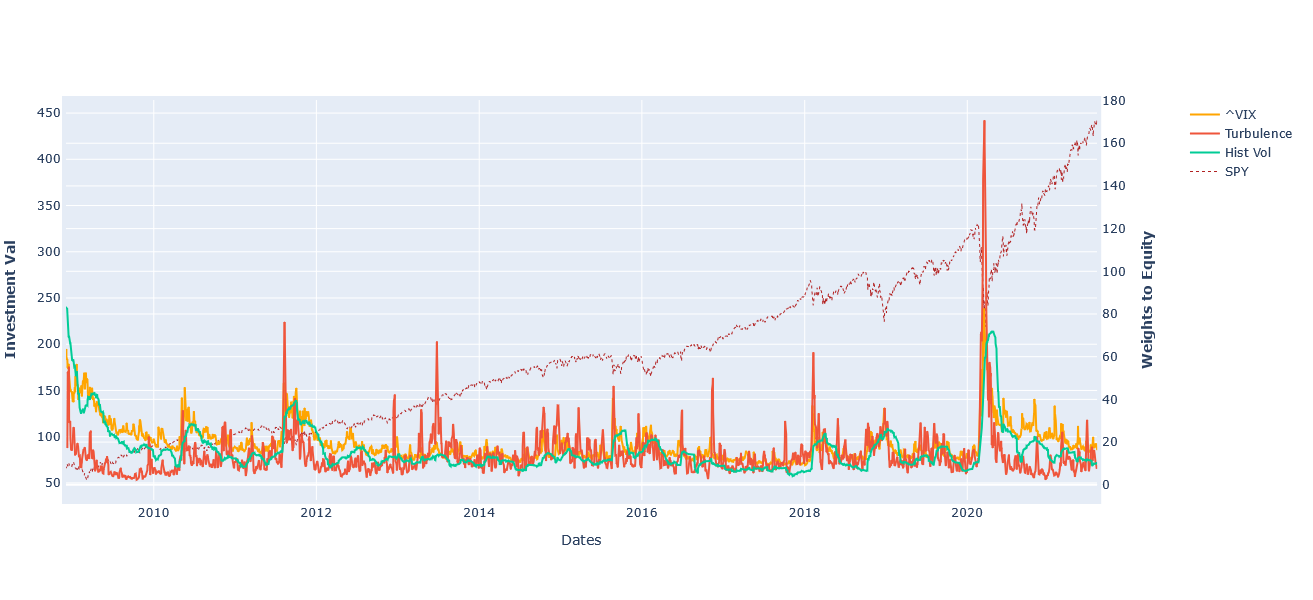

In [55]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def plotly_charting(df):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x= df.index.values,  y=df['^VIX'], name='^VIX',line = dict(color='orange', width=2)),secondary_y=True,)
    fig.add_trace(go.Scatter(x= df.index.values,  y=df['turbulence'].rolling(5).mean(), name='Turbulence',line = dict( width=2)),secondary_y=True,)
    fig.add_trace(go.Scatter(x= df.index.values,  y=df['SPY_Hist_vol_2m'], name='Hist Vol',line = dict( width=2)),secondary_y=True,)
    fig.add_trace(go.Scatter(x= df.index.values,  y=df['SPY'], name='SPY',line = dict(color='firebrick', width=1, dash='dot')),secondary_y=False,)
    # Set x-axis title
    fig.update_xaxes(title_text="Dates")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Investment Val</b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>Weights to Equity</b>", secondary_y=True)
    fig.update_layout(
        autosize=False,
        width=1200,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor="White",
    )

    fig.show()
plotly_charting(mat)


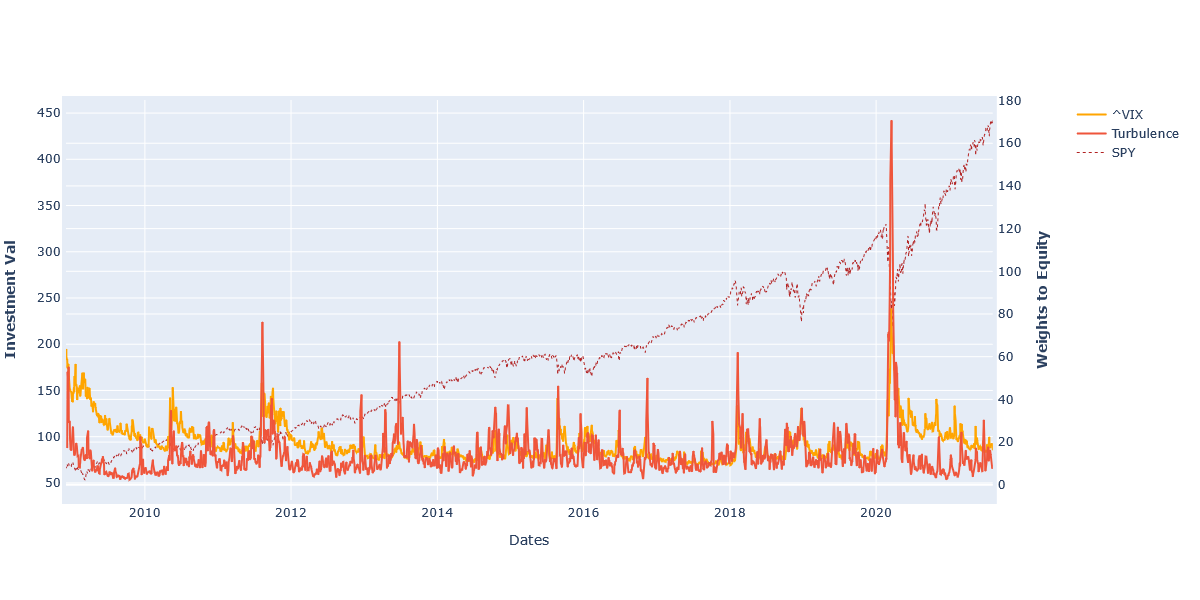

In [57]:
from IPython.display import Image
Image("vix_turbulence.png")